In [4]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from timeit import default_timer as timer
from numba import autojit
from numba import cuda
from numba import *

In [2]:
def colors_img_gen(green=0):
    width = height = 256
    img = np.zeros((width, height, 3), dtype = np.uint8)
    for x in range(width):
        img[:, x] = np.full((256, 3), np.array([x, green, 255-x]), dtype= np.uint8)
    return img

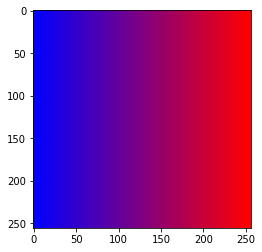

In [3]:
img = colors_img_gen()
plt.imshow(img, animated=True)

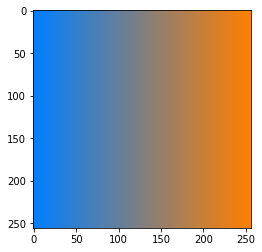

In [4]:
img = colors_img_gen(255/2)
plt.imshow(img, animated=True)

In [5]:
width, height = 2**9, 2**9
max_red = 1
ratio = 5
green = max_red / 2
size = (height/ (ratio * 2), width/(ratio * 2))
values = None
Lu = None
center_indxs = None
im = None

In [6]:
def init():
    global Lu, center_indxs, values, im
    Lu = np.zeros((height, width), dtype=np.float64)
    center_indxs = int(height/2 - size[0]), int(height/2 + size[0]), int(width/2 - size[1]), int(width/2 + size[1]) 
    values = np.zeros((height, width), dtype = np.float64)
    values[center_indxs[0]: center_indxs[1], center_indxs[2]: center_indxs[3]] = np.array(1)
    im = plt.imshow(values, animated=True)
    plt.set_cmap('hot')

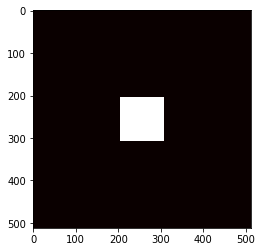

In [7]:
init()

In [8]:
def check_image_square(c=0):
    return values[center_indxs[0] - c: center_indxs[1] + c, center_indxs[2] - c: center_indxs[3] + c]

In [9]:
def laplacian_cell(values, x, y):
    return  np.sum(values[x - 1: x + 2, y] + values[x, y - 1: y + 2]) - 6 * values[x, y]

In [10]:
def one_iter(*args):
    dt=0.1
    for x in range(1, height - 1):
        for y in range(1, width - 1):
            Lu[x, y] = laplacian_cell(values, x, y)
    
    values[1:-1, 1:-1] +=  dt * Lu[1:-1, 1:-1]
    im.set_array(values)
    return im,

In [11]:
one_iter()

(<matplotlib.image.AxesImage at 0x2098a59c198>,)

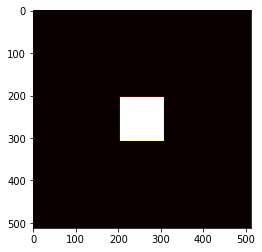

In [12]:
plt.imshow(values)

In [ ]:
for _ in range(100):
    one_iter()

In [ ]:
plt.imshow(values)
plt.colorbar()

Better version with numpy

In [18]:
from scipy.ndimage.filters import laplace

In [19]:
# better one itter version
def one_iter_np(*args):
    dt=0.1
    for _ in range(15):
        values[1:-1, 1:-1] +=  dt * laplace(values)[1:-1, 1:-1]
    im.set_array(values)
    return im,

LETS ANIMATE

<IPython.core.display.Javascript object>


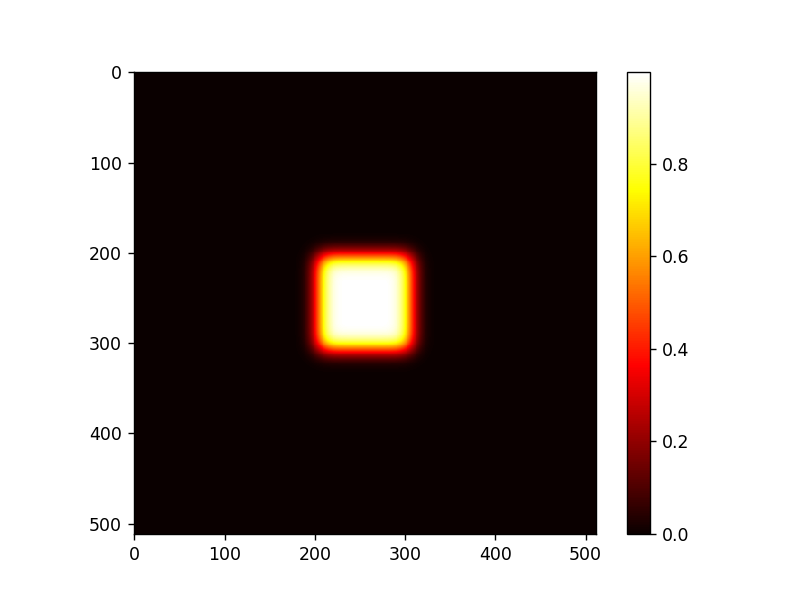

In [20]:
%matplotlib notebook
fig = plt.figure()
im = plt.imshow(values, animated=True)
plt.colorbar()
# here you c
ani = FuncAnimation(fig, one_iter_np, init_func=init, interval=10, blit=True)
plt.show()

# LETS GO FOR CUDA THIS TIME 

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from timeit import default_timer as timer
from numba import autojit
from numba import cuda
from numba import *
from numba import autojit
from numba import vectorize

In [21]:
@cuda.jit(device=True)
def laplacian_cell_gpu(values, x, y):
    if x > 0 and x < values.shape[0] - 1 and y > 0 and y < values.shape[1] - 1:
        return  values[x, y - 1] + values[x, y + 1] + values[x - 1, y] + values[x + 1, y] - 4 * values[x, y]
    return 0.

In [22]:
@cuda.jit
def laplace_kernel(values, Lu):
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;
    
    for x in range(startX, width, gridX):
        for y in range(startY, height, gridY):
            Lu[y, x] = laplacian_cell_gpu(values, y, x)

In [23]:
@cuda.jit
def add_dt(values, Lu):
    dt = 0.1
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;
    
    for x in range(startX, width, gridX):
        for y in range(startY, height, gridY):
            values[y, x] += dt* Lu[y, x]

In [24]:
def one_iter_with_kernel(values, Lu):
    laplace_kernel[griddim, blockdim](values, Lu)
    cuda.synchronize()
    add_dt[griddim, blockdim](values, Lu)
    cuda.synchronize()


In [25]:
def animation_iter(*args):
    for _ in range(100):
        one_iter_with_kernel(values_gpu, Lu_gpu)
    values_gpu.to_host()
    im.set_array(values)
    return im,

In [26]:
width, height = 2**9, 2**9
max_red = 1
ratio = 5
green = max_red / 2
size = (height/ (ratio * 2), width/(ratio * 2))
values = None
Lu = None
center_indxs = None
im = None

Variabile pentru cuda

In [27]:
blockdim = None
griddim = None
values_gpu = None
Lu_gpu = None

In [28]:
def init_gpu():
    global values, blockdim, griddim, Lu, values_gpu, Lu_gpu, im, center_indxs
    
    Lu = np.zeros((height, width), dtype=np.float64)
    center_indxs = int(height/2 - size[0]), int(height/2 + size[0]), int(width/2 - size[1]), int(width/2 + size[1]) 
    values = np.zeros((height, width), dtype = np.float64)
    values[center_indxs[0]: center_indxs[1], center_indxs[2]: center_indxs[3]] = np.array(1)
    plt.set_cmap('hot')
    
    # cuda stuff
    values_gpu = cuda.to_device(values)
    Lu_gpu = cuda.to_device(Lu)
    blockdim = 16, 4
    griddim = 16, 8
    im = plt.imshow(values, animated=True)

<IPython.core.display.Javascript object>


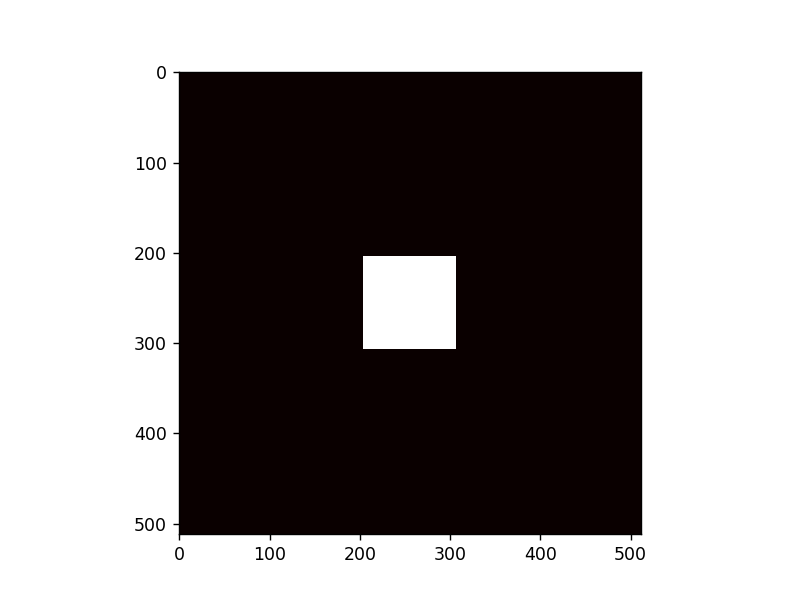

In [29]:
init_gpu()

In [30]:
Lu_gpu

In [31]:
values_gpu

In [32]:
laplace_kernel[griddim, blockdim](values_gpu, Lu_gpu)

In [33]:
Lu_gpu.to_host()

In [34]:
c = 0
Lu[center_indxs[0] - c: center_indxs[1] + c, center_indxs[2] - c: center_indxs[3] + c]

array([[-2., -1., -1., ..., -1., -1., -2.],
       [-1.,  0.,  0., ...,  0.,  0., -1.],
       [-1.,  0.,  0., ...,  0.,  0., -1.],
       ...,
       [-1.,  0.,  0., ...,  0.,  0., -1.],
       [-1.,  0.,  0., ...,  0.,  0., -1.],
       [-2., -1., -1., ..., -1., -1., -2.]])

In [35]:
add_dt[griddim, blockdim](values_gpu, Lu_gpu)

In [36]:
values_gpu.to_host()

In [37]:
c = 0
values[center_indxs[0] - c: center_indxs[1] + c, center_indxs[2] - c: center_indxs[3] + c]

array([[0.8, 0.9, 0.9, ..., 0.9, 0.9, 0.8],
       [0.9, 1. , 1. , ..., 1. , 1. , 0.9],
       [0.9, 1. , 1. , ..., 1. , 1. , 0.9],
       ...,
       [0.9, 1. , 1. , ..., 1. , 1. , 0.9],
       [0.9, 1. , 1. , ..., 1. , 1. , 0.9],
       [0.8, 0.9, 0.9, ..., 0.9, 0.9, 0.8]])

<IPython.core.display.Javascript object>


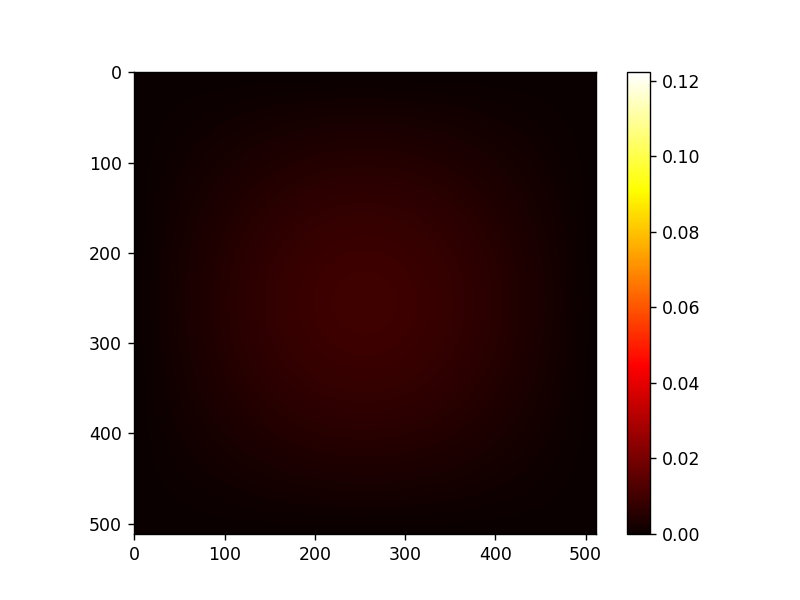

In [39]:
%matplotlib notebook
fig = plt.figure()
im = plt.imshow(values, animated=True)
plt.colorbar()
# here you c
ani = FuncAnimation(fig, animation_iter, init_func=init_gpu, interval=10, blit=True)
plt.show()

# Astea au fost testele initiale teste 

In [14]:
a = np.zeros((100, 100), dtype=np.float64)
a[:, :] = np.array(1.)
b = np.zeros((100, 100), dtype=np.float64)
b[:, :] = np.array(10.)

@cuda.jit(device=True)
def calc(values, x, y):
    return values[x, y] + 100

@cuda.jit
def inc_mat(mat, mat2):
    height, width = mat.shape
    
    x = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x
    y = cuda.blockDim.y * cuda.blockIdx.y + cuda.threadIdx.y
    
    mat2[x, y] = calc(mat, x , y)
    

@cuda.jit
def add_ufunc(mat, mat2):
    dt = 0.1
    x = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x
    y = cuda.blockDim.y * cuda.blockIdx.y + cuda.threadIdx.y
    mat[x, y] = dt* mat2[x, y]


def main(mat, mat2):
    cuda.synchronize()
    inc_mat[griddim, blockdim](mat, mat2)
    cuda.synchronize()
    add_ufunc[griddim, blockdim](gp_vals, gp_vals2)

In [15]:
cuda.synchronize
gp_vals = cuda.to_device(a)
gp_vals2 = cuda.to_device(b)
blockdim = (10, 10)
griddim = (10, 10)

In [16]:
main(gp_vals, gp_vals2)

In [17]:
gp_vals.to_host()
gp_vals2.to_host()

In [18]:
a

array([[10.1, 10.1, 10.1, ..., 10.1, 10.1, 10.1],
       [10.1, 10.1, 10.1, ..., 10.1, 10.1, 10.1],
       [10.1, 10.1, 10.1, ..., 10.1, 10.1, 10.1],
       ...,
       [10.1, 10.1, 10.1, ..., 10.1, 10.1, 10.1],
       [10.1, 10.1, 10.1, ..., 10.1, 10.1, 10.1],
       [10.1, 10.1, 10.1, ..., 10.1, 10.1, 10.1]])

In [19]:
b

array([[101., 101., 101., ..., 101., 101., 101.],
       [101., 101., 101., ..., 101., 101., 101.],
       [101., 101., 101., ..., 101., 101., 101.],
       ...,
       [101., 101., 101., ..., 101., 101., 101.],
       [101., 101., 101., ..., 101., 101., 101.],
       [101., 101., 101., ..., 101., 101., 101.]])